In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as sp
import scipy.stats as st
import QuantLib as ql
import yfinance as yf
import datetime as dt
# from fredapi import Fred
import quandl

c:\Users\Julia\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


PART 1: Set up 10-year SP500 historical data; volatility and risk-free rate at present

In [2]:
#set up the start and end date
start_date = dt.datetime(2024, 1, 1) - dt.timedelta(days=10*365)
end_date = dt.datetime(2024, 1, 1) 
# get sp500 data
sp500_data = yf.download('^GSPC', start=start_date, end=end_date)
sp500 = sp500_data['Close'].values

# ! take the interest rate of 2024.01.01

#get the 3 year treasury rate
# api_key = "ff0cc3c956ef0838181b3d1603e8ce98"
# fred = Fred(api_key=api_key)
# treasury_3yr = fred.get_series('GS3', frequency='m',start_date=start_date, end_date=end_date)
quandl.ApiConfig.api_key = '19PYgzG1hHNM7wZyy6NF' 
treasury_history = quandl.get("USTREASURY/YIELD.7", start_date=start_date, end_date=end_date, column_index=1)/100
# print(treasury_history)
current_rate = float(treasury_history.iloc[-1].values)

# calculate the volatility and log returns
log_returns = np.log(sp500[1:] / sp500[:-1])  # Compute log returns using array operations
volatility = np.sqrt(252)*np.std(log_returns)
print(f"volatility={volatility:.2%}, Rate at {end_date}={current_rate:.2%}")

[*********************100%%**********************]  1 of 1 completed

c:\Users\Julia\anaconda3\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



volatility=17.80%, Rate at 2024-01-01 00:00:00=4.01%


C:\Users\Julia\AppData\Local\Temp\ipykernel_23396\214503704.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_rate = float(treasury_history.iloc[-1].values)


PART 2: Define the Superclass "BullSpread" , which contain basic information Black-Scholes Model methods (Pricing; Delta Hedging)
 

In [3]:
class BullSpread:
    def __init__(self, S, g, G, r, t,T, sigma,L):
        self.S0 = S  # undelying
        self.contract = L / S
        self.S = self.S0 * self.contract
        self.r = r  # risk-free rate
        self.t = t
        self.T = T  # expiration time
        self.Term = T-t
        self.sigma = sigma  # volatility
        self.K1 = (1+g)**(self.Term)*L # low strike price
        self.K2 = (1+G)**(self.Term)*L # high strike price
        self.discount = np.exp(-self.r * self.Term)
        self.g = g
        self.G = G
        self.L = L
        # print(f"K1={self.K1},K2={self.K2},S={self.S}")

    def black_scholes_call_price(self, K):
        d1 = (np.log(self.S / K) + (self.r + 0.5 * self.sigma**2) * self.Term) / (self.sigma * np.sqrt(self.Term))
        d2 = d1 - self.sigma * np.sqrt(self.Term)
        call_price =  self.S * st.norm.cdf(d1) - self.discount * K * np.exp(-self.r * self.T) * st.norm.cdf(d2)
        return call_price
    
    def black_scholes_call_delta(self, K,contract):
        d1 = (np.log(self.S0 * contract / K) + (self.r + 0.5 * self.sigma**2) * self.Term) / (self.sigma * np.sqrt(self.Term))
        # print(f"d1={d1},S={self.S},K={K},r={self.r},sigma={self.sigma},Term={self.Term}")
        call_delta = st.norm.cdf(d1)
        # print(f"call_delta={call_delta}")
        return call_delta

    def bull_spread_price(self):
        call_price_K1 = self.black_scholes_call_price(self.K1)
        call_price_K2 = self.black_scholes_call_price(self.K2)
        # print(f"call_price_K1={call_price_K1},call_price_K2={call_price_K2}")
        bull_spread_price = self.discount * self.K1 + call_price_K1 - call_price_K2
        return bull_spread_price
    
    def bull_spread_delta(self,contract):
        call_delta_K1 = self.black_scholes_call_delta(self.K1,contract)
        call_delta_K2 = self.black_scholes_call_delta(self.K2,contract)
        # print(f"call_delta_K1={call_delta_K1},call_delta_K2={call_delta_K2}")
        bull_spread_delta = call_delta_K1 - call_delta_K2
        return bull_spread_delta
    
    def Delta_Hedge(self, St):
    # Initial values
        D0=self.bull_spread_delta(self.contract)
        dt=self.Term/len(St)
        Fund = [self.L]
        Delta = [D0]
        Bank = [self.L-D0*self.S]
        for i in range(1,len(St)):
            Fund = np.append(Fund,Bank[i-1]*np.exp(self.r*dt)+Delta[i-1]*St[i]*self.contract) # update fund, St now starts with S0
            tempory_option=BullSpread(St[i], self.g, self.G, self.r,i*dt,self.T, self.sigma, self.L)
            new_delta=tempory_option.bull_spread_delta(self.contract)
            Delta = np.append(Delta,new_delta) # update delta at the rebalance day
            Bank = np.append(Bank,Fund[i]-Delta[i]*St[i]*self.contract) # update bank account
        # print(f"tempory_option={tempory_option.Term}")
        # print(f"Bank={Bank[-1]},Delta={Delta[-1]},St={len(St)}")
        Fund_T = Bank[-1]*np.exp(self.r*dt)+Delta[-1]*St[-1]*self.contract
        return (Fund_T-max(min(self.K2,St[-1]*self.contract),self.K1))


PART 3: Define the subclass "VasicekBullSpread" which contains special information and method from Vasicek model (Pricing; Delta Hedging)

In [4]:
class VasicekBullSpread(BullSpread):
    def __init__(self, S, g, G, r, t, T, sigma, L, alpha, beta, gamma,rho):
        super().__init__(S, g, G, r, t, T, sigma, L)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.rho = rho
        self.A_t_T = 1/self.alpha*(1-np.exp(-self.alpha*self.Term))
        self.B_t_T = (self.beta-self.beta**2/2/self.alpha**2)*(self.A_t_T-self.Term)-self.gamma**2*self.A_t_T**2/4/self.alpha
        self.G_t_T = self.gamma/(self.alpha*np.sqrt(self.Term-self.A_t_T-self.alpha*self.A_t_T**2/2))
        self.vol = self.sigma**2 + self.G_t_T**2 - 2 * self.rho * self.sigma * self.G_t_T
        self.C_t_T = self.beta * self.Term + (self.r -self.beta) *self.A_t_T
        self.P_t_T = np.exp(-self.r*self.A_t_T+self.B_t_T)
        self.Fv = -self.Term * self.K1 * np.exp(-self.r*self.Term)
        self.Pv = -self.A_t_T * np.exp(-self.r*self.A_t_T+self.B_t_T)
        self.rho_i = self.Fv/self.Pv
        # print(f"self.alpha={self.alpha},self.beta={self.beta},self.gamma={self.gamma},self.rho={self.rho}")
        # print(f"A_t_T={self.A_t_T},B_t_T={self.B_t_T},G_t_T={self.G_t_T},vol={self.vol},C_t_T={self.C_t_T},P_t_T={self.P_t_T}")
        
    def vasicek_call_price(self, K):
        d1 = (np.log(self.S / K) + self.C_t_T - 0.5 * self.vol *self.Term) / (self.sigma * np.sqrt(self.Term))+np.sqrt(self.vol)*self.Term
        d2 = (np.log(self.S / K) + self.C_t_T - 0.5 * self.vol *self.Term) / (self.sigma * np.sqrt(self.Term))+self.G_t_T*self.Term
        # print(f"d1={d1},d2={d2}")
        call_price = self.S * st.norm.cdf(d1) -  K * self.P_t_T * st.norm.cdf(d2)
        return call_price
    
    def bull_spread_Vasicek_price(self):
        call_price_K1 = self.vasicek_call_price(self.K1)
        call_price_K2 = self.vasicek_call_price(self.K2)
        bull_spread_price = self.discount * self.K1 + call_price_K1 - call_price_K2
        return bull_spread_price
    
    def Vasicek_call_delta(self, K, contract):
        d1 = (np.log(self.S0 * contract / K) + self.C_t_T - 0.5 * self.vol *self.Term) / (self.sigma * np.sqrt(self.Term))+np.sqrt(self.vol)*self.Term
        call_delta = st.norm.cdf(d1)
        return call_delta
    
    def Vasicek_call_rho(self, K ,contract):
        d2 = (np.log(self.S0 * contract / K) + self.C_t_T - 0.5 * self.vol *self.Term) / (self.sigma * np.sqrt(self.Term))+self.Term*self.G_t_T
        call_rho = st.norm.cdf(d2)
        return call_rho
    
    def Vasicek_bull_spread_delta(self,contract):
        call_delta_K1 = self.black_scholes_call_delta(self.K1,contract)
        call_delta_K2 = self.black_scholes_call_delta(self.K2,contract)
        # print(f"call_delta_K1={call_delta_K1},call_delta_K2={call_delta_K2}")
        bull_spread_delta = call_delta_K1 - call_delta_K2
        return bull_spread_delta
    
    def Vasicek_bull_spread_rho(self,contract):
        call_rho_K1 = self.Vasicek_call_rho(self.K1,contract)
        call_rho_K2 = self.Vasicek_call_rho(self.K2,contract)
        # bull_spread_rho = call_rho_K1 - call_rho_K2
        # print(f"call_rho_K1={call_rho_K1},call_rho_K2={call_rho_K2}")
        return call_rho_K1, call_rho_K2
    
    def Delta_Hedge_Vasicek(self, St):
    # Initial values
        D0=self.Vasicek_bull_spread_delta(self.contract)
        dt=self.Term/len(St)
        Fund = [self.L]
        Delta = [D0]
        Bank = [self.L-D0*self.S]
        for i in range(1,len(St)):
            Fund = np.append(Fund,Bank[i-1]*np.exp(self.r*dt)+Delta[i-1]*St[i]*self.contract) # update fund, St now starts with S0
            tempory_option=VasicekBullSpread(St[i], self.g, self.G, self.r,i*dt,self.T, self.sigma, self.L,self.alpha,self.beta,self.gamma,self.rho)
            new_delta=tempory_option.Vasicek_bull_spread_delta(self.contract)
            Delta = np.append(Delta,new_delta) # update delta at the rebalance day
            Bank = np.append(Bank,Fund[i]-Delta[i]*St[i]*self.contract) # update bank account
        # print(f"Bank={Bank[-1]},Delta={Delta[-1]}")
        Fund_T = Bank[-1]*np.exp(self.r*dt)+Delta[-1]*St[-1]*self.contract
        return (Fund_T-max(min(self.K2,St[-1]*self.contract),self.K1))
    
    def Rho_Hedge_Vasicek(self, St, Rt):
        Rho1_0,Rho2_0=self.Vasicek_bull_spread_rho(self.contract)
        # print(f"Rho1_0={Rho1_0},Rho2_0={Rho2_0}")
        dt=self.Term/len(St)
        Fund = [self.L]
        Rho1 = [Rho1_0]
        Rho2 = [Rho2_0]
        Rho_future = [self.rho_i]
        Bank = [
        self.L - (
        Rho1_0 * self.K1 * self.P_t_T -  # hedge the long call option
        Rho2_0 * self.K2 * self.P_t_T +  # hedge the short call option
        Rho_future[0] * self.P_t_T)]         # hedge the future
        # print(f"Bank={Bank[-1]}")
        for i in range(1,len(Rt)):
            #!this should not use Rt[i] list but calculate another r that is between (t,T)
            tempory_option=VasicekBullSpread(St[i], self.g, self.G, Rt[i],i*dt,self.T, self.sigma, self.L,self.alpha,self.beta,self.gamma,self.rho) 
            interest_capital = Bank[i-1]*np.exp(Rt[i-1]*dt)                                # pay for interest rate
            call_option_long_hedge_capital = Rho1[i-1] * tempory_option.P_t_T * self.K1  # from long option rho hedge
            call_option_short_hedge_captital = Rho2[i-1] * tempory_option.P_t_T * self.K2   # the short position rho hedge
            future_hedge_capital = tempory_option.P_t_T * Rho_future[i-1]                     # the future rho hedge
            net_capital = interest_capital + call_option_long_hedge_capital - call_option_short_hedge_captital+future_hedge_capital
            # print(f"interest_income={interest_income},call_option_long_hedge_income={call_option_long_hedge_income},call_option_short_hedge_loss={call_option_short_hedge_loss},future_hedge_income={future_hedge_income},net_income={net_income}")
            Fund = np.append(Fund, net_capital)        
            new_rho=tempory_option.Vasicek_bull_spread_rho(self.contract)
            # print(f"new_rho={new_rho},tempory option P_t_T={tempory_option.P_t_T}")
            Rho1 = np.append(Rho1, new_rho[0]) 
            Rho2 = np.append(Rho2, new_rho[1])# update delta at the rebalance day
            Rho_future = np.append(Rho_future, tempory_option.rho_i) # update bank account
            call_option_long_hedge_c2 = Rho1[i] * tempory_option.P_t_T * self.K1
            call_option_short_hedge_c2 = Rho2[i] * tempory_option.P_t_T * self.K2
            future_hedge_capital_c2 = tempory_option.P_t_T * Rho_future[i]
            net_c2_from_hedge = call_option_long_hedge_c2 - call_option_short_hedge_c2 + future_hedge_capital_c2
            Bank = np.append(Bank,Fund[i]-net_c2_from_hedge)     #pkus the short position
        # for bank_value in Bank:
        #     print(f"Bank={bank_value:.2f}")
        
        BankT=Bank[-1]*np.exp(Rt[-1]*dt)           #bank account
        Option1_T=Rho1[-1]*tempory_option.P_t_T*self.K1      #long position
        Option2_t=Rho2[-1]*tempory_option.P_t_T*self.K2      #short position
        Future_T=tempory_option.P_t_T*tempory_option.rho_i  #future
        Fund_T = BankT+Option1_T-Option2_t+Future_T
        # print(f"Bank={Bank[-1]}, Rho1={Rho1[-1]},Rho2={Rho2[-1]},Rho_future={Rho_future[-1]}")
        # print(f"Fund_T={Fund_T}")
        X=max(min(self.K2,St[-1]*self.contract),self.K1)
        return Fund_T-X
    
    def DeltaRho_Hedge_Vasicek(self, St, Rt):
        Rho1_0,Rho2_0=self.Vasicek_bull_spread_rho(self.contract)
        D0=self.Vasicek_bull_spread_delta(self.contract)
        # print(f"Rho1_0={Rho1_0},Rho2_0={Rho2_0}")
        dt=1/252
        Fund = [self.L]
        Rho1 = [Rho1_0]
        Rho2 = [Rho2_0]
        Delta = [D0]
        Rho_future = [self.rho_i]
        Bank = [
        self.L - (
        D0*self.S+                       # delta hedge
        Rho1_0 * self.K1 * self.P_t_T -  # hedge the long call option
        Rho2_0 * self.K2 * self.P_t_T +  # hedge the short call option
        Rho_future[0] * self.P_t_T)]         # hedge the future
        # print(f"Bank={Bank[-1]}")
        for i in range(1,len(Rt)):
            #!this should not use Rt[i] list but calculate another r that is between (t,T)
            # to simplify the calculation, we use the historical 3-year rate Rt
            tempory_option=VasicekBullSpread(St[i], self.g, self.G, Rt[i],i*dt,self.T, self.sigma, self.L,self.alpha,self.beta,self.gamma,self.rho) 
            interest_capital = Bank[i-1]*np.exp(Rt[i-1]*dt)                                # pay for interest rate
            call_option_long_hedge_capital = Rho1[i-1] * tempory_option.P_t_T * self.K1  # from long option rho hedge
            call_option_short_hedge_captital = Rho2[i-1] * tempory_option.P_t_T * self.K2   # the short position rho hedge
            future_hedge_capital = tempory_option.P_t_T * Rho_future[i-1]                     # the future rho hedge
            delta_capital = St[i]*self.contract * Delta[i-1]
            net_income = interest_capital + call_option_long_hedge_capital - call_option_short_hedge_captital+future_hedge_capital + delta_capital
            # print(f"interest_income={interest_income},call_option_long_hedge_income={call_option_long_hedge_income},call_option_short_hedge_loss={call_option_short_hedge_loss},future_hedge_income={future_hedge_income},net_income={net_income}")
            Fund = np.append(Fund, net_income)        
            new_rho=tempory_option.Vasicek_bull_spread_rho(self.contract)
            Rho1 = np.append(Rho1, new_rho[0]) 
            Rho2 = np.append(Rho2, new_rho[1])# update delta at the rebalance day
            Rho_future = np.append(Rho_future, tempory_option.rho_i) # update bank account
            Delta = np.append(Delta,tempory_option.Vasicek_bull_spread_delta(self.contract))
            call_option_long_hedge_c2 = Rho1[i] * tempory_option.P_t_T * self.K1
            call_option_short_hedge_c2 = Rho2[i] * tempory_option.P_t_T * self.K2
            future_hedge_capital_c2 = tempory_option.P_t_T * Rho_future[i]
            delta_capital_c2 = St[i] * self.contract * Delta[i]
            net_c2_from_hedge = call_option_long_hedge_c2 - call_option_short_hedge_c2 + future_hedge_capital_c2+delta_capital_c2
            Bank = np.append(Bank,Fund[i]-net_c2_from_hedge)     #pkus the short position
        # print(f"Bank={Bank[-1]},Fund={Fund[-1]}")
        # for bank_value in Bank:
        #     print(f"Bank={bank_value:.2f}")
        BankT=Bank[-1]*np.exp(Rt[-1]*dt)           #bank account
        Option1_T=Rho1[-1]*tempory_option.P_t_T*self.K1      #long position
        Option2_t=Rho2[-1]*tempory_option.P_t_T*self.K2      #short position
        Future_T=tempory_option.P_t_T*tempory_option.rho_i  #future
        Delta_T=Delta[-1]*St[-1]*self.contract
        Fund_T = BankT+Option1_T-Option2_t+Future_T+Delta_T
        X=max(min(self.K2,St[-1]*self.contract),self.K1)
        print("X=",X)
        return Fund_T-X

Part 4: g-G estimating (Based on BS model)

In [5]:
T=3
np.random.seed(2000)
S0 = sp500[-1]  # underlying price
L = 200000
start=0

g_list=[0, 0.005,0.01, 0.015,0.02,-0.005,-0.01,-0.015,-0.02]
G_list_BS=[]
for g in g_list:
    simulated_G= sp.newton(lambda G:BullSpread(S0, g, G, current_rate, start, T, volatility, L).bull_spread_price()-L,g,tol=1e-8)
    G_list_BS.append(simulated_G)
    print(f"g={g:.2%}, G={simulated_G:.2%}")

g=0.00%, G=7.27%
g=0.50%, G=6.92%
g=1.00%, G=6.57%
g=1.50%, G=6.20%
g=2.00%, G=5.81%
g=-0.50%, G=7.60%
g=-1.00%, G=7.93%
g=-1.50%, G=8.24%
g=-2.00%, G=8.54%


PART 5: Past 3-year delta hedging (Based on BS model)

In [6]:
# set up new start and end dates
start_date = dt.datetime(2021, 1, 1)
end_date = dt.datetime(2023, 12, 31)
# get 3 year sp500 data
sp500_3y = yf.download('^GSPC', start=start_date, end=end_date)
sp500_3y = sp500_3y['Close'].values
treasury_3yr = quandl.get("USTREASURY/YIELD.7", start_date=start_date, end_date=end_date, column_index=1)/100
rate_2021 = float(treasury_3yr.iloc[0].values)

S0=sp500_3y[0]
BS_G_offical= sp.newton(lambda G:BullSpread(S0, 0, G, rate_2021, start, T, volatility, L).bull_spread_price()-L,g,tol=1e-8)
print(f"Rate at {start_date}: {rate_2021:.2%}\n g={0:.2%}, G={BS_G_offical:.2%}")

BS_option=BullSpread(S0, 0, BS_G_offical, rate_2021,start, T, volatility, L)
delta_hedge_results=BS_option.Delta_Hedge(sp500_3y)
print(f"Delta hedged results=${delta_hedge_results:.2f}")

[*********************100%%**********************]  1 of 1 completed

c:\Users\Julia\anaconda3\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



Rate at 2021-01-01 00:00:00: 0.16%
 g=0.00%, G=0.36%
Delta hedged results=$-665.91


C:\Users\Julia\AppData\Local\Temp\ipykernel_23396\4247143785.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rate_2021 = float(treasury_3yr.iloc[0].values)


PART 6: g-G estimating (Based on Vasicek Model)

In [7]:
alpha = 0.3
beta = 0.04
gamma = 0.02
rho = 0.5
G_list_Vasicek=[]
for g in g_list:
    simulated_G= sp.newton(lambda G:VasicekBullSpread(S0, g, G, current_rate,start, T, volatility, L ,alpha, beta, gamma, rho).bull_spread_Vasicek_price()-L,g+0.06,tol=1e-8)
    G_list_Vasicek.append(simulated_G)
    print(f"g={g:.2%}, G={simulated_G:.2%}")

g=0.00%, G=7.48%
g=0.50%, G=7.12%
g=1.00%, G=6.75%
g=1.50%, G=6.36%
g=2.00%, G=5.95%
g=-0.50%, G=7.82%
g=-1.00%, G=8.14%
g=-1.50%, G=8.43%
g=-2.00%, G=8.71%


PART 7: Acquire daily date of 3-year interest rate and estimating alpha, beta and gamma (Maximum Likelihood)

In [8]:
def vasicek_model_estimete_parameter(params, r):
    alpha, beta, gamma = params
    dt = 1 / 252  
    r_shift = np.roll(r, 1)
    r_shift[0] = 0  
    dr = r[1:] - r_shift[1:]
    mu = alpha * (beta - r[:-1]) * dt
    sigma = gamma * np.sqrt(dt)
    likelihood = -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (dr - mu) ** 2 / sigma ** 2)
    return -likelihood

initial_guess = [0.05, 0.03, 0.02]  # alpha, beta, gamma
# bounds = [(0, None), (0, 0.2), (None, None)]
result = sp.minimize(vasicek_model_estimete_parameter, initial_guess, args=(treasury_history.values.flatten(),))
alpha_hat, beta_hat, gamma_hat = result.x


In [9]:
delta = 1 / 252
common_dates = sp500_data.index.intersection(treasury_history.index)
St = sp500_data.loc[common_dates]['Close'].values
rt = treasury_history.loc[common_dates].values
# print(min(rt))
# print(len(St),len(rt))
def Xt_simulation():
    simulations = []
    for _ in range(len(rt)-1):
        Xt=(rt[_+1] - rt[_] - alpha_hat * (beta_hat - rt[_]) * delta) / np.sqrt(delta * rt[_])
        simulations.append(Xt)
    return simulations
Xt_simulation=Xt_simulation()
mu_hat= 252*np.mean(log_returns)
def Yt_simulation():
    simulations = []
    for _ in range(len(St)-1):
        Yt=(St[_+1] - St[_] - St[_] * mu_hat * delta) / (St[_] * np.sqrt(delta )* volatility)
        simulations.append(Yt)
    return simulations
Yt_simulation=Yt_simulation()
#estimates rho
Xt_simulation = [float(arr[0]) for arr in Xt_simulation]
rho_hat=np.corrcoef(Xt_simulation,Yt_simulation)[0,1]
rho_hat

[0.001]


0.20812949226726551

In [10]:
treasury_history.to_csv('treasury_history.csv')


{'1/12': 0.055999999999999994, '2/12': 0.0559, '3/12': 0.054000000000000006, '6/12': 0.0526, '1': 0.0479, '2': 0.042300000000000004, '3': 0.0401, '5': 0.0384}
Alpha: 6.289185128162494
Beta: 0.1252038778071502
Gamma: 2.621085140768087


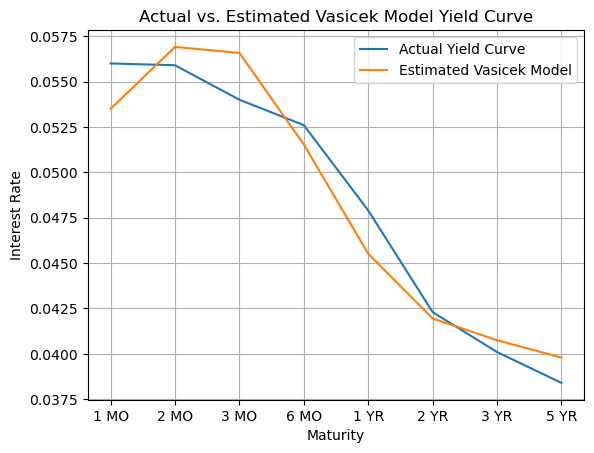

([0.05349986227728815,
  0.05690946984888182,
  0.056578685682242946,
  0.05153323791930215,
  0.04551411211002088,
  0.041949663527499625,
  0.04075283882124114,
  0.03979535969646158],
 [0.055999999999999994,
  0.0559,
  0.054000000000000006,
  0.0526,
  0.0479,
  0.042300000000000004,
  0.0401,
  0.0384])

In [11]:
import matplotlib.pyplot as plt

quandl.ApiConfig.api_key = '19PYgzG1hHNM7wZyy6NF' 
yield_curve_data = quandl.get("USTREASURY/YIELD", start_date="2023-12-29", end_date="2024-01-01")
yield_curve = yield_curve_data.iloc[0]/100
yield_curve_data = yield_curve.to_dict()
del yield_curve_data['7 YR']
del yield_curve_data['10 YR']
del yield_curve_data['20 YR']
del yield_curve_data['30 YR']
yield_curve = {key.replace(' MO', '/12').replace(' YR', ''): value for key, value in yield_curve_data.items()}
print(yield_curve)
def vasicek_model(params, T,r0):
    alpha, beta, gamma = params
    T = eval(T)
    A_t_T=1/alpha*(1-np.exp(-alpha*(T)))
    B_t_T=(beta-gamma**2/2/alpha**2)*(A_t_T-(T))-gamma**2*A_t_T**2/4/alpha
    P_t_T=np.exp(-r0*A_t_T+B_t_T)
    y_t_T=-np.log(P_t_T)/T
    # print(f"y_t_T={y_t_T},P_t_T={P_t_T},A_t_T={A_t_T},B_t_T={B_t_T},T={T}")
    return y_t_T

# 定义目标函数，最小化实际利率和模型预测利率之间的差异
def objective_function(params):
    sum_of_squares = 0.0
    for maturity, rate in yield_curve.items():
        predicted_rate = vasicek_model(params, maturity,current_rate)
        sum_of_squares += (rate - predicted_rate) ** 2
    # print(f"sum_of_squares={sum_of_squares}")
    return sum_of_squares

# 初始化参数估计值
initial_guess = [0.05, 0.04, 0.03]  # 随意选择一些初始值
bounds=[(0, None), (0,  None), (0, None)]
# 使用SciPy中的minimize函数进行参数估计
result = sp.minimize(objective_function, initial_guess,bounds=bounds)

# 输出参数估计结果
alpha, beta, gamma = result.x
print("Alpha:", alpha)
print("Beta:", beta)
print("Gamma:", gamma)

# 生成用于绘制的时间范围
T_range = list(yield_curve.keys())

# 使用估计的参数计算Vasicek模型的利率
estimated_rates = [vasicek_model(result.x, T, current_rate) for T in T_range]

# 绘制实际债券收益率曲线
plt.plot(list(yield_curve_data.keys()),list(yield_curve.values()), label="Actual Yield Curve")
# 绘制估计的Vasicek模型曲线
plt.plot(list(yield_curve_data.keys()), estimated_rates, label="Estimated Vasicek Model")

plt.xlabel('Maturity')
plt.ylabel('Interest Rate')
plt.title('Actual vs. Estimated Vasicek Model Yield Curve')
plt.legend()
plt.grid(True)
plt.show()
list(yield_curve.values())
estimated_rates, list(yield_curve.values())

In [12]:
print("Estimated Parameters:")
print(f"Alpha:{alpha_hat:.5f} \nBeta:{beta_hat:.5f} \nGamma:{gamma_hat:.5f} \nRho:{rho_hat:.5f}")

Estimated Parameters:
Alpha:0.19888 
Beta:0.03354 
Gamma:0.01035 
Rho:0.20813


PART 8: Apply calibrated estimators to estimate alpha, beta, gamma again (Vasicek Model)

In [13]:
G_list_Vasicek_Calibration=[]
    
for g in g_list:
    simulated_G= sp.newton(lambda G:VasicekBullSpread(S0, g, G, current_rate,start, T, volatility, L ,alpha_hat, beta_hat, gamma_hat, rho_hat).bull_spread_Vasicek_price()-L,g,tol=1e-8)
    G_list_Vasicek_Calibration.append(simulated_G)
    print(f"g={g:.2%}, G={simulated_G:.2%}")
    
# G_list_Vasicek_Calibration_yield_curve=[]    
# for g in g_list:
#     simulated_G= sp.newton(lambda G:VasicekBullSpread(S0, g, G, current_rate,start, T, volatility, L ,alpha_est, beta_est, gamma_est, rho_hat).bull_spread_Vasicek_price()-L,g+0.06,tol=1e-8)
#     G_list_Vasicek_Calibration_yield_curve.append(simulated_G)
#     print(f"g={g:.2%}, G={simulated_G:.2%}")

g=0.00%, G=8.64%
g=0.50%, G=8.09%
g=1.00%, G=7.55%
g=1.50%, G=7.00%
g=2.00%, G=6.45%
g=-0.50%, G=9.18%
g=-1.00%, G=9.71%
g=-1.50%, G=10.24%
g=-2.00%, G=10.77%


PART 9: Past 3-year delta AND rho hedging (Based on Vasicek model)

In [14]:
start_date = dt.datetime(2021, 1, 1)
end_date = dt.datetime(2023, 12, 31)
quandl.ApiConfig.api_key = '19PYgzG1hHNM7wZyy6NF' 
treasury_3yr_daily = quandl.get("USTREASURY/YIELD.7", start_date=start_date, end_date=end_date, column_index=1).values/100
treasury_3yr_daily = [item[0] for item in treasury_3yr_daily]
Vasicek_G_offical= sp.newton(lambda G:VasicekBullSpread(S0, 0, G, rate_2021,start, T, volatility, L ,alpha_hat, beta_hat, gamma_hat, rho_hat).bull_spread_Vasicek_price()-L,g+0.06,tol=1e-8)
print(f"Rate at {start_date}: {rate_2021:.2%}\n g={0:.2%}, G={Vasicek_G_offical:.2%}")

Rate at 2021-01-01 00:00:00: 0.16%
 g=0.00%, G=0.32%


In [15]:
Vasicek_option=VasicekBullSpread(S0, 0,Vasicek_G_offical, rate_2021,start, T, volatility, L, alpha_hat, beta_hat, gamma_hat, rho_hat)
delta_hedge_results=Vasicek_option.Delta_Hedge_Vasicek(sp500_3y)
print(f"delta hedged results=${delta_hedge_results:.2f}")

delta hedged results=$-481.86


In [16]:

rho_hedge_results=Vasicek_option.Rho_Hedge_Vasicek(sp500_3y,treasury_3yr_daily)
print(f"Rho hedged results=${rho_hedge_results:.2f}")
delta_rho_hedge_results=Vasicek_option.DeltaRho_Hedge_Vasicek(sp500_3y,treasury_3yr_daily)
print(f"Delta-Rho hedged results=${delta_rho_hedge_results:.2f}")

Rho hedged results=$-267.36
X= 201931.63933238352
Delta-Rho hedged results=$122.95


In [17]:
#backtest
print("R0=",treasury_3yr_daily[0])
print("length of Rt=",len(treasury_3yr_daily))
def backtest(Rt):
    cumulated=200000
    for i in range(len(Rt)):
        cumulated = np.exp(Rt[i]/250)*cumulated
    return cumulated
print(f"Backtest results=${backtest(treasury_3yr_daily):.2f}")

R0= 0.0016
length of Rt= 750
Backtest results=$216227.30


PART 10: Define the subclass "StochasticVolatilityBullSpread" which contains special information and method from Stochastic Volatility model (Pricing; Delta Hedging)

In [18]:
class StochasticVolatilityBullSpread(VasicekBullSpread):
    def __init__(self, S, g, G, r, t, T, sigma, L, alpha, beta, gamma, rho, kappa, theta, volvol,rho2, v0):
        super().__init__(S, g, G, r, t, T, sigma, L, alpha, beta, gamma, rho)
        self.kappa = kappa 
        self.theta = theta
        self.volvol = volvol
        self.rho2 = rho2
        self.v0 = v0
        

    def heston_bull_spread_price(self):
        call_price_K1 = self.generate_stock_path(self.K1)
        call_price_K2 = self.generate_stock_path(self.K2)
        bull_spread_price = self.discount * self.K1 + call_price_K1 - call_price_K2
        return bull_spread_price
    
    def generate_stock_path(self, K):
        n=10000
        n_steps = 252
        dt = self.Term / n_steps
        np.random.seed(2024)
        Z1 = np.random.normal(size=(n_steps, n))
        Z2 = self.rho2 * Z1 + np.sqrt(1 - self.rho2 ** 2) * np.random.normal(size=(n_steps, n)) #random shock for volatility
        Z3 = self.rho * Z1 + np.sqrt(1 - self.rho ** 2) * np.random.normal(size=(n_steps, n)) #random shock for interest rate
        S = np.zeros((n_steps + 1, n))
        v = np.zeros((n_steps + 1, n))
        R = np.zeros((n_steps + 1, n))
        S[0] = self.S
        v[0] = self.v0
        R[0] = self.r
        #print(S0, maturity, r, kappa, theta, volvol, rho, n_steps, n_simulations, dt)
        for i in range(1, n_steps + 1):
            S[i] = S[i - 1] * np.exp((self.r - 0.5 * v[i - 1]) * dt + np.sqrt(v[i - 1] * dt) * Z1[i - 1])
            v[i] = np.maximum(v[i - 1] + self.kappa * (self.theta - v[i - 1]) * dt + self.volvol * np.sqrt(v[i - 1] * dt) * Z2[i - 1], 0)
            R[i] = np.maximum(R[i - 1] + self.alpha * (self.beta - R[i - 1]) * dt + self.gamma * np.sqrt(dt) * Z3[i - 1], 0)
        payoffs = np.maximum(S[-1] - K, 0)
        option_price = self.discount * payoffs
        return np.mean(option_price)
    

    

PART 11: Stochastic Volatility Model

In [19]:
start_date = dt.datetime(2024, 1, 1) - dt.timedelta(days=10*365)
end_date = dt.datetime(2024, 1, 1) 
vix_data = yf.download('^VIX', start=start_date, end=end_date)
vix = vix_data['Close'].values
vix_history = (vix/100)**2

[*********************100%%**********************]  1 of 1 completed


c:\Users\Julia\anaconda3\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [20]:
vt=vix_history
kappa=10
def Xt(t,theta):
    return (vt[t+1] - vt[t] - kappa * (theta - vt[t]) * delta) / np.sqrt(delta * vt[t])
def avgXt(theta):
    return np.mean([Xt(t, theta) for t in range(len(vt)-1)])
theta=sp.newton(lambda theta:avgXt(theta),10)
def Xt_simulation():
    simulations = []
    for _ in range(len(vt)-1):
        Xt=(vt[_+1] - vt[_] - kappa * (theta - vt[_]) * delta) / np.sqrt(delta * vt[_])
        simulations.append(Xt)
    return simulations
Xt_simulation=Xt_simulation()
volvol=np.var(Xt_simulation)
St=sp500
def Yt(t,mu):
    return (St[t+1] - St[t] - St[t] * mu * delta) / (St[t] * np.sqrt(delta * vt[t]))
def avgYt(mu):
    return np.mean([Yt(t, mu) for t in range(len(vt)-1)])
mu=sp.newton(lambda mu:avgYt(mu),10)
def Yt_simulation():
    simulations = []
    for _ in range(len(St)-1):
        Yt=(St[_+1] - St[_] - St[_] * mu_hat * delta) / (St[_] * np.sqrt(delta * vt[_]))
        simulations.append(Yt)
    return simulations
Yt_simulation=Yt_simulation()
rho_hat_vol=np.corrcoef(Xt_simulation,Yt_simulation)[0, 1]

print("Initial Parameters:")
print(f"Kappa:{kappa:.5f} \nTheta:{theta:.5f} \nVolvol:{volvol:.5f} \nRho:{rho_hat_vol:.5f}")

Initial Parameters:
Kappa:10.00000 
Theta:0.03514 
Volvol:0.42425 
Rho:-0.71006


PART 12: Calibrate Stochastic Volatility Model

In [21]:
def heston_model_estimete_parameter(params, r):
    kappa, theta, volvol = params
    dt = 1 / 252  
    r_shift = np.roll(r, 1)
    r_shift[0] = 0  
    dr = r[1:] - r_shift[1:]
    mu = kappa * (theta - r[:-1]) * dt
    sigma = volvol * np.sqrt(dt)
    likelihood = -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (dr - mu) ** 2 / sigma ** 2)
    return -likelihood

initial_guess = [0.05, 0.03, 0.02]  # alpha, beta, gamma
# bounds = [(0, None), (0, 0.2), (None, None)]
result = sp.minimize(heston_model_estimete_parameter, initial_guess, args=(vix_history,))
kappa_hat, theta_hat, volvol_hat = result.x

print("Optimized Parameters:")
print(f"Kappa:{kappa_hat:.5f} \nTheta:{theta_hat:.5f} \nVolvol:{volvol_hat:.5f} \nRho:{rho_hat_vol:.5f}")

Optimized Parameters:
Kappa:13.61236 
Theta:0.03820 
Volvol:0.22239 
Rho:-0.71006


PART 13: estimate g-G based on stochastic volatility model

In [22]:
G_list_Heston=[]

start_date = dt.datetime(2024, 1, 1)
end_date = dt.datetime.now()
vix_new = yf.download('^VIX', start=start_date, end=end_date)
vix_n = ((vix_new['Close'].values)/100)**2
vo = vix_n[0]
for g in g_list:
    simulated_G= sp.newton(lambda G:StochasticVolatilityBullSpread(S0, g, G, current_rate,start, T, volatility, L, alpha_hat, beta_hat, gamma_hat, rho_hat, kappa_hat, theta_hat, volvol_hat, rho_hat_vol,vo).heston_bull_spread_price()-L,g+0.06,tol=1e-8)
    G_list_Heston.append(simulated_G)
    print(f"g={g:.2%}, G={simulated_G:.2%}")

[*********************100%%**********************]  1 of 1 completed


c:\Users\Julia\anaconda3\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


g=0.00%, G=9.61%
g=0.50%, G=8.94%
g=1.00%, G=8.26%
g=1.50%, G=7.58%
g=2.00%, G=6.90%
g=-0.50%, G=10.30%
g=-1.00%, G=10.99%
g=-1.50%, G=11.69%
g=-2.00%, G=12.40%


PART 14: Investigate Difference in g-G

In [23]:
print(f"Rate at {start_date} = {current_rate:.2%}")
print(f"Average Rate (Mean Reversion Level) = {beta_hat:.2%}")
print(f"Volatility at {start_date} = {np.sqrt(vo):.2%}")
print(f"Average Volatility at (Mean Reversion Level) = {np.sqrt(theta_hat):.2%}")
print(f"Volatility Square at {start_date}= {vo:.2%}")
print(f"Average Volatility Square at (Mean Reversion Level) = {theta_hat:.2%}")


Rate at 2024-01-01 00:00:00 = 4.01%
Average Rate (Mean Reversion Level) = 3.35%
Volatility at 2024-01-01 00:00:00 = 13.20%
Average Volatility at (Mean Reversion Level) = 19.54%
Volatility Square at 2024-01-01 00:00:00= 1.74%
Average Volatility Square at (Mean Reversion Level) = 3.82%


* GARCH MODEL

In [24]:
from arch import arch_model
start_date = dt.datetime(2024, 1, 1) - dt.timedelta(days=1*365)
end_date = dt.datetime(2024, 1, 1) 
sp500_data = yf.download('^GSPC', start=start_date, end=end_date)
sp500 = sp500_data['Close'].values
S0 = sp500[-1]

quandl.ApiConfig.api_key = '19PYgzG1hHNM7wZyy6NF' 
treasury_history = quandl.get("USTREASURY/YIELD.7", start_date=start_date, end_date=end_date, column_index=1)/100
current_rate = float(treasury_history.iloc[-1].values)


[*********************100%%**********************]  1 of 1 completed

c:\Users\Julia\anaconda3\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


C:\Users\Julia\AppData\Local\Temp\ipykernel_23396\854815215.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_rate = float(treasury_history.iloc[-1].values)


In [25]:
start_date = dt.datetime(2024, 1, 1) - dt.timedelta(days=10*365)
end_date = dt.datetime(2024, 1, 1)

vix = yf.download('^VIX', start=start_date, end=end_date)
vix_data = vix['Close'].values

# GARCH
model = arch_model(vix_data, vol='Garch', p=1, q=1)  # 我们改为GARCH(1,1)模型
result = model.fit()
omega = result.params['omega']
alpha = result.params['alpha[1]']
beta = result.params['beta[1]']

initial_volatility = vix_data[-1]  # 
T = 252 * 3  

volatility_path = np.zeros(T)
volatility_path[0] = initial_volatility

# simulate path
for t in range(1, T):
    volatility_path[t] = np.sqrt(omega + alpha * volatility_path[t-1]**2 + beta * vix_data[-t]**2)

[*********************100%%**********************]  1 of 1 completed
Iteration:      1,   Func. Count:      6,   Neg. LLF: 8350607948.4466305
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1655161573.0919487
Iteration:      3,   Func. Count:     19,   Neg. LLF: 36337.3074492383
Iteration:      4,   Func. Count:     25,   Neg. LLF: 26548.86690216142
Iteration:      5,   Func. Count:     31,   Neg. LLF: 7181.730335525123
Iteration:      6,   Func. Count:     37,   Neg. LLF: 202275.36799239612
Iteration:      7,   Func. Count:     43,   Neg. LLF: 6853.853943451664
Iteration:      8,   Func. Count:     48,   Neg. LLF: 6800.925710541648
Iteration:      9,   Func. Count:     53,   Neg. LLF: 39672.31339770514
Iteration:     10,   Func. Count:     59,   Neg. LLF: 6792.864337703582
Iteration:     11,   Func. Count:     64,   Neg. LLF: 6787.406695706052
Iteration:     12,   Func. Count:     69,   Neg. LLF: 6786.831814567824
Iteration:     13,   Func. Count:     74,   Neg. LLF: 6786.786569

c:\Users\Julia\anaconda3\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
